In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [ ]:
def expected_naive_loss(n, m, p, super_naive=False):
    """
    n is the number of inputs
    m is the number of hidden nodes
    p is the probability that any given input node is not zero (i.e.) within [-1, 1]
    super_naive means that we have a model that just predicts 0 always
    """
    if super_naive:
        return p/6
    
    return (p/6) * (n-m)/n

In [ ]:
def get_trained_model_and_loss(
    n,
    m,
    p,
    learning_rate = 1e-3,
    batch_size = 256,
    epochs = 20,
    n_samples = 100_000,
    plot=False,
):
    """
    n is the number of inputs
    m is the number of hidden nodes
    p is the probability that any given input node is not zero (i.e.) within [-1, 1]
    n_samples is the number of random datapoints (of size n) to generate
    """
    n_input = n
    n_hidden = m
    n_output = n_input

    # Get predicted losses
    naive_loss = expected_naive_loss(n=n_input, m=n_hidden, p=p, super_naive=False)
    naive_loss_all_zero = expected_naive_loss(n=n_input, m=n_hidden, p=p, super_naive=True)

    # Generate data
    mask = torch.rand([n_samples, n_input]) < p
    x = mask * (2 * torch.rand([n_samples, n_input]) - 1)
    y = nn.functional.relu(x)

    # Define model
    model = torch.nn.Sequential(
        nn.Linear(n_input, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_output),
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    dataloader = DataLoader(
        TensorDataset(x, y), 
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )

    training_stats = defaultdict(list)
    iterable_ = range(epochs)
    for epoch in (tqdm(iterable_) if plot else iterable_):
        for batch_x, batch_y in dataloader:
            # batch_x = batch_x.to(device)
            # batch_y = batch_y.to(device)
        
            y_pred = model(batch_x)
            loss = torch.nn.functional.mse_loss(y_pred, batch_y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            full_pred = model(x)        
            epoch_loss = torch.nn.functional.mse_loss(full_pred, y)
        training_stats['epoch'].append(epoch)
        training_stats['loss'].append(epoch_loss.item())

        if plot:
            training_stats_df = pd.DataFrame(training_stats)
            clear_output(wait=True)
            plt.clf()

            ax = sns.lineplot(data=training_stats_df, x='epoch', y='loss')
            ax.set_yscale("log")
            plt.show()

        if len(training_stats["loss"]) > 1 and ((training_stats['loss'][-1] - training_stats['loss'][-2]) > -1e-6):
            break

    return {
        "n": n,
        "m": m,
        "p": p,
        "model_loss": epoch_loss.item(),
        "naive_loss": naive_loss,
        "naive_loss_all_zero": naive_loss_all_zero,
    }, model

/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


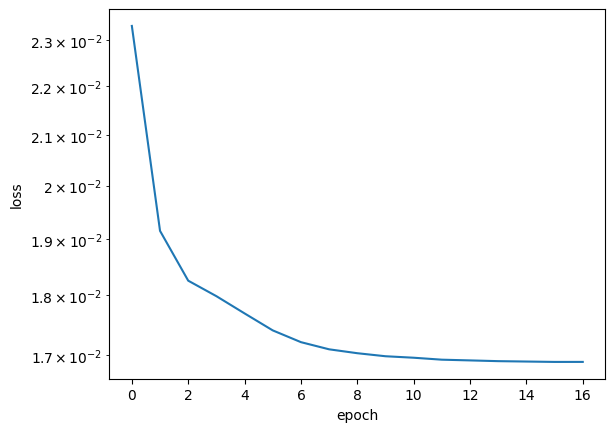

({'n': 10,
  'm': 5,
  'p': 0.2,
  'model_loss': 0.016887683421373367,
  'naive_loss': 0.016666666666666666,
  'naive_loss_all_zero': 0.03333333333333333},
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): ReLU()
   (2): Linear(in_features=5, out_features=10, bias=True)
 ))

In [4]:
get_trained_model_and_loss(n=10, m=5, p=0.2, plot=True)

In [ ]:
stats_list = []
for n in tqdm([2, 3, 5, 10]):
    for m in tqdm(range(1, 10)):
        if m > n:
            continue

        for p in [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1]:
            stats_list.append(get_trained_model_and_loss(n=n, m=m, p=p, plot=False))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
res_df = pd.DataFrame([d_ for d_, model_ in stats_list])
res_df["n_minus_m"] = res_df["n"] - res_df["m"]
res_df["model_loss_over_naive_loss"] = res_df["model_loss"] / res_df["naive_loss"]
res_df

,n,m,p,model_loss,naive_loss,naive_loss_all_zero,n_minus_m,model_loss_over_naive_loss
0,2,1,0.00,1.308975e-10,0.000000,0.000000,1,inf
1,2,1,0.01,8.881605e-04,0.000833,0.001667,1,1.065793
2,2,1,0.05,6.079019e-03,0.004167,0.008333,1,1.458965
3,2,1,0.10,1.644326e-02,0.008333,0.016667,1,1.973191
4,2,1,0.20,2.264157e-02,0.016667,0.033333,1,1.358494
...,...,...,...,...,...,...,...,...
166,10,9,0.20,3.047082e-03,0.003333,0.033333,1,0.914125
167,10,9,0.50,1.192586e-02,0.008333,0.083333,1,1.431103
168,10,9,0.80,9.388238e-03,0.013333,0.133333,1,0.704118
169,10,9,0.90,9.947456e-03,0.015000,0.150000,1,0.663164


In [31]:
res_df[res_df["n_minus_m"] == 0][["model_loss", "naive_loss"]].describe()

,model_loss,naive_loss
count,2.700000e+01,27.0
mean,5.195023e-03,0.0
std,1.055707e-02,0.0
min,4.791898e-15,0.0
25%,1.667890e-09,0.0
50%,8.366757e-06,0.0
75%,4.565895e-03,0.0
max,4.663678e-02,0.0


Now exclude the case where n=m, because in that case we expect a loss of zero. Note that in fact there were some models that didn't achieve a tiny loss, probably something isn't perfect with the training.

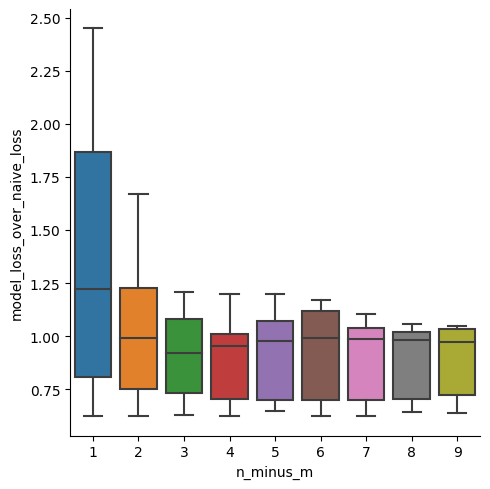

In [26]:
sns.catplot(data=res_df[res_df["n_minus_m"] > 0], x="n_minus_m", y="model_loss_over_naive_loss", kind="box")

We can see many cases where the model did indeed perform better than the naive case (anywhere were the y-axis is under 1). Interestingly plenty of cases where the model did worse, especially when `n-m=1`, I didn't have time to explore that further, maybe these models needed more time to train?

/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


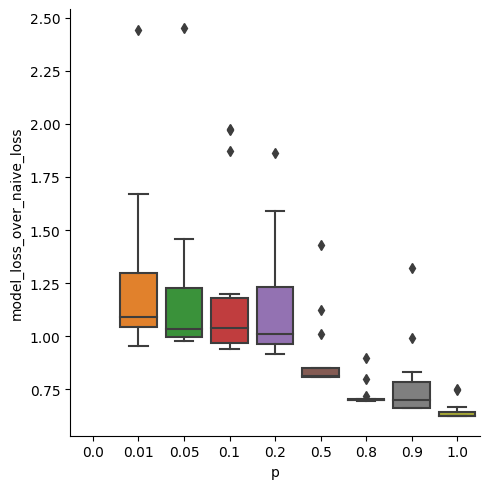

In [32]:
sns.catplot(data=res_df[res_df["n_minus_m"] > 0], x="p", y="model_loss_over_naive_loss", kind="box")

Interestingly when p is low, the model doesn't quite get a loss as low as the naive loss. My guess is that because it is so sparse, it needs a lot more time to train, as p gets much higher, we have a lot more data and the model can start learning interesting things (superposition?).